# Targeting EGLN1 in Cervical Cancer:
###Using a machine learning model to predict new compounds bioactive against EGLN1

**Package Installation**

In [1]:
# Installing the packages
!pip install chembl-webresource-client
!pip install rdkit-pypi
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176717 sha256=d0462de72529d157ddfd99a17f01b38d97d1c20e70418d03b3150a43dca75f34
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3


In [2]:
# Importing necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import rdkit
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors

**Data Retrieving from ChEMBL database**

In [3]:
# Target search for EGLN1 protein
my_target = new_client.target
my_target_query = my_target.search('EGLN1')

In [5]:
# generating a dataframe structure for target data
my_targets = pd.DataFrame.from_dict(my_target_query)
my_targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Rattus norvegicus,Egl nine homolog 1,13.0,False,CHEMBL3638322,"[{'accession': 'P59722', 'component_descriptio...",SINGLE PROTEIN,10116
1,"[{'xref_id': 'Q9GZT9', 'xref_name': None, 'xre...",Homo sapiens,Egl nine homolog 1,12.0,False,CHEMBL5697,"[{'accession': 'Q9GZT9', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,Hypoxia-inducible factor prolyl hydroxylase,6.0,False,CHEMBL3831261,"[{'accession': 'Q96KS0', 'component_descriptio...",PROTEIN FAMILY,9606


In [6]:
# picking the exact match for the model training (homo sapiens, single protein)
selected_target = my_targets.target_chembl_id[1]
selected_target

'CHEMBL5697'

In [8]:
# filtering for activity (IC50)
activity = new_client.activity
data = activity.filter(target_chembl_id=selected_target).filter(standard_type= "IC50" )

In [9]:
#generating a dataframe for raw training data
df = pd.DataFrame.from_dict(data)

In [10]:
# viewing the first 5 rows of the data
df.head(5)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1806060,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.7
1,None,None,1806061,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,1.4
2,None,None,1806062,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,12.0
3,None,None,1806063,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,0.19
4,None,None,1806064,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.8


**Data Cleaning and Preprocessing**

In [11]:
# dropping NaN values in the standard value and canonical SMILES column
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]

<ipython-input-11-2e57bd74f422>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df.canonical_smiles.notna()]


In [12]:
df2

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1806060,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.7
1,None,None,1806061,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,1.4
2,None,None,1806062,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,12.0
3,None,None,1806063,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,0.19
4,None,None,1806064,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989073,[],CHEMBL5229130,Inhibition of N-terminal His-tagged human PHD2...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,419.0
1263,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989079,[],CHEMBL5229133,Inhibition of PHD2 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,6.0
1264,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989080,[],CHEMBL5229133,Inhibition of PHD2 (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,3.9
1265,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989088,[],CHEMBL5229138,Inhibition of N-terminal truncated PHD2 (unkno...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,409.0


In [13]:
# dropping duplicate data entries
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1806060,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.7
1,None,None,1806061,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,1.4
2,None,None,1806062,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,12.0
3,None,None,1806063,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,0.19
4,None,None,1806064,[],CHEMBL855663,Inhibition of human EGLN1,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,None,None,24989062,[],CHEMBL5229127,Inhibition of human PHD2 expressed in H5 insec...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,10000.0
1260,None,None,24989064,[],CHEMBL5229127,Inhibition of human PHD2 expressed in H5 insec...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,10000.0
1261,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989072,[],CHEMBL5229130,Inhibition of N-terminal His-tagged human PHD2...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,7300.0
1262,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24989073,[],CHEMBL5229130,Inhibition of N-terminal His-tagged human PHD2...,B,None,None,BAO_0000190,...,Homo sapiens,Egl nine homolog 1,9606,None,None,IC50,uM,UO_0000065,None,419.0


In [15]:
# streamlinig the data to chembl ID, canonical smiles and standard value
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,2700.0
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,1400.0
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,12000.0
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,190.0
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,2800.0
...,...,...,...
1258,CHEMBL1160006,O=C(O)CC(C(=O)O)C(=O)O,10000000.0
1260,CHEMBL1455497,O=C(O)CC(O)C(=O)O,10000000.0
1261,CHEMBL1614745,O=C(O)CC[C@@H](O)C(=O)O,7300000.0
1262,CHEMBL1615211,O=C(O)CC[C@H](O)C(=O)O,419000.0


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,2700.0
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,1400.0
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,12000.0
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,190.0
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,2800.0
...,...,...,...
1258,CHEMBL1160006,O=C(O)CC(C(=O)O)C(=O)O,10000000.0
1260,CHEMBL1455497,O=C(O)CC(O)C(=O)O,10000000.0
1261,CHEMBL1614745,O=C(O)CC[C@@H](O)C(=O)O,7300000.0
1262,CHEMBL1615211,O=C(O)CC[C@H](O)C(=O)O,419000.0


In [16]:
# defining a function for the standard values (active, inactive and intermediate)
bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 10000:
   bioactivity_threshold.append ("inactive")
  elif float(i) <= 1000:
   bioactivity_threshold.append ("active")
  else:
   bioactivity_threshold.append ("intermediate")

In [17]:
df3.head()

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,2700.0
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,1400.0
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,12000.0
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,190.0
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,2800.0


In [18]:
# creating a new column named "class" for the bioactivity
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,2700.0,intermediate
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,1400.0,intermediate
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,12000.0,inactive
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,190.0,active
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,2800.0,intermediate


In [19]:
# **Calculate Lipinski descriptors**
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation



def lipinski(smiles, verbose=False):
    moldata = []

    # Loop through each SMILES string and convert to RDKit Mol object
    for elem in smiles:

        # Check if elem is a valid SMILES string before converting
        if isinstance(elem, str):
            mol = Chem.MolFromSmiles(elem)
            moldata.append(mol)

    # Initialize baseData as an empty list to hold the descriptor data
    baseData = []
    i = 0

    # Loop through each molecule and calculate Lipinski descriptors
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        # Create a row with the calculated descriptors
        row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])

        i += 1

    # Define column names for the DataFrame
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]

    # Create a DataFrame with the descriptor data
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [20]:
# generating the lipinski values using the canonical smiles into a dataframe
df_lipinski = lipinski(df4.canonical_smiles)
df_lipinski


,MW,LogP,NumHDonors,NumHAcceptors
0,309.325,2.68230,1.0,5.0
1,280.667,1.40820,3.0,4.0
2,189.174,0.96550,1.0,4.0
3,410.433,4.22098,1.0,6.0
4,369.377,2.69950,1.0,7.0
...,...,...,...,...
1099,162.097,-0.75350,3.0,3.0
1100,134.087,-1.09340,3.0,3.0
1101,148.114,-0.70330,3.0,3.0
1102,148.114,-0.70330,3.0,3.0


In [21]:
# concatinating the initial dataframe with that with the lipinski values
df_combined = pd.concat([df4,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,2700.0,intermediate,309.325,2.68230,1.0,5.0
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,1400.0,intermediate,280.667,1.40820,3.0,4.0
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,12000.0,inactive,189.174,0.96550,1.0,4.0
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,190.0,active,410.433,4.22098,1.0,6.0
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,2800.0,intermediate,369.377,2.69950,1.0,7.0
...,...,...,...,...,...,...,...,...
1090,NaN,NaN,NaN,intermediate,333.260,0.64840,4.0,8.0
1092,NaN,NaN,NaN,intermediate,337.335,2.49840,4.0,5.0
1098,NaN,NaN,NaN,inactive,192.123,-1.24850,4.0,4.0
1102,NaN,NaN,NaN,inactive,148.114,-0.70330,3.0,3.0


In [22]:
df_combined.standard_value.describe()

,standard_value
count,1104
unique,639
top,200000.0
freq,53


In [23]:
#generating the pIC50 from the IC50
def pIC50(input_data):
    pIC50 = []

    for i in input_data['standard_value']:
        try:
            # This will try to convert i to a float
            i = float(i)
            # Convert nM to M (nanomolar to molar)
            molar = i * (10**-9)
        except ValueError:
            # If i is not a number, set molar to 0
            molar = 0

        # Calculate pIC50 and append it to the list
        pIC50.append(-np.log10(molar))

    # Add the pIC50 values as a new column in the dataframe
    input_data['pIC50'] = pIC50

    # Drop the 'standard_value' column
    output_data = input_data.drop('standard_value', axis=1)

    return output_data


In [24]:
# adding the pIC50 column to the data
df_final = pIC50(df_combined)
df_final

<ipython-input-23-90dba9007698>:16: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,intermediate,309.325,2.68230,1.0,5.0,5.568636
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,intermediate,280.667,1.40820,3.0,4.0,5.853872
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,inactive,189.174,0.96550,1.0,4.0,4.920819
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,active,410.433,4.22098,1.0,6.0,6.721246
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,intermediate,369.377,2.69950,1.0,7.0,5.552842
...,...,...,...,...,...,...,...,...
1090,NaN,NaN,intermediate,333.260,0.64840,4.0,8.0,NaN
1092,NaN,NaN,intermediate,337.335,2.49840,4.0,5.0,NaN
1098,NaN,NaN,inactive,192.123,-1.24850,4.0,4.0,NaN
1102,NaN,NaN,inactive,148.114,-0.70330,3.0,3.0,NaN


In [25]:
# dropping all NaN values
df_cleaned = df_final.dropna()
df_cleaned

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,intermediate,309.325,2.68230,1.0,5.0,5.568636
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,intermediate,280.667,1.40820,3.0,4.0,5.853872
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,inactive,189.174,0.96550,1.0,4.0,4.920819
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,active,410.433,4.22098,1.0,6.0,6.721246
4,CHEMBL374147,COc1cc(COCc2ccc(-n3cc(C(=O)O)cn3)nc2)cc(OC)c1,intermediate,369.377,2.69950,1.0,7.0,5.552842
...,...,...,...,...,...,...,...,...
1096,CHEMBL4557378,O=C1N(c2ccc(-c3ccccc3)cc2)C(=O)C2(CCN(Cc3ncc[n...,inactive,358.354,1.04700,4.0,6.0,6.667562
1097,CHEMBL4514222,COc1cccc(CN2CCC3(CC2)C(=O)N(c2ccc(-c4ccccc4)cc...,inactive,325.324,1.07420,3.0,4.0,5.917215
1099,CHEMBL4482885,Cn1ccnc1CN1CCC2(CC1)NC(=O)N(c1ccc(-c3ccccc3)cc...,inactive,162.097,-0.75350,3.0,3.0,6.821023
1100,CHEMBL4535543,COc1ccnc(N2C(=O)N(c3ccc(-c4ccccc4)cc3)C(=O)C23...,inactive,134.087,-1.09340,3.0,3.0,6.539102


In [26]:
# Check for missing values (NaN)
print(df_cleaned.isna().sum())  # Count of NaN values in each column

# Check for infinite values (inf)
print((df_cleaned == np.inf).sum())  # Count of inf values in each column
print((df_cleaned == -np.inf).sum())  # Count of -inf values in each column


molecule_chembl_id    0
canonical_smiles      0
class                 0
MW                    0
LogP                  0
NumHDonors            0
NumHAcceptors         0
pIC50                 0
dtype: int64
molecule_chembl_id    0
canonical_smiles      0
class                 0
MW                    0
LogP                  0
NumHDonors            0
NumHAcceptors         0
pIC50                 1
dtype: int64
molecule_chembl_id    0
canonical_smiles      0
class                 0
MW                    0
LogP                  0
NumHDonors            0
NumHAcceptors         0
pIC50                 0
dtype: int64


In [27]:
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
df_cleaned = df_cleaned.dropna()  # Drop rows with NaN values


In [28]:
df_cleaned.pIC50.describe()

,pIC50
count,966.000000
mean,5.686893
std,1.576713
min,2.000000
25%,4.508638
50%,5.319212
75%,6.657577
max,9.698970


**Exploratory Data Analysis**

In [30]:
## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**
# importing visualization libraries
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

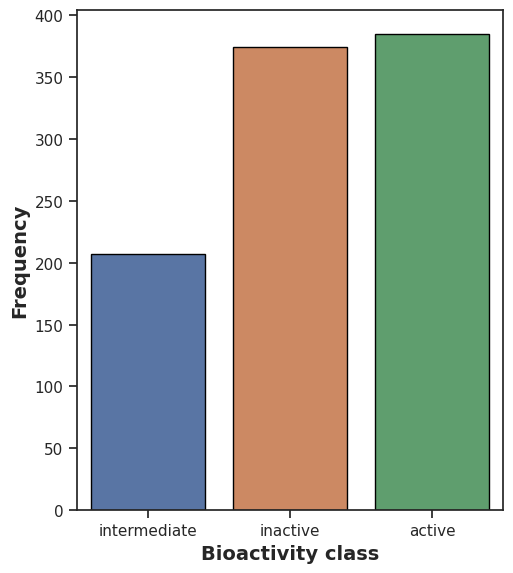

In [31]:
# visualising the biocativity class of the data
plt.figure(figsize=(5.5, 6.5))

sns.countplot(x='class', data=df_cleaned, edgecolor='black', hue = 'class')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')



In [33]:
# getting the smiles
def cannonical_smile(smiles):
   mols = [Chem.MolFromSmiles(i) for i in smiles]
   smiles =  [Chem.MolToSmiles(mol) for mol in mols]
   return smiles

In [34]:
# import libraries
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [35]:
#previewing the data
df_cleaned.head(4)

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL221189,O=C(O)c1cnn(-c2ccc(COCc3ccccc3)cn2)c1,intermediate,309.325,2.68230,1.0,5.0,5.568636
1,CHEMBL426560,O=C(O)CNC(=O)c1nc(Cl)c2ccccc2c1O,intermediate,280.667,1.40820,3.0,4.0,5.853872
2,CHEMBL220743,O=C(O)c1cnn(-c2ccccn2)c1,inactive,189.174,0.96550,1.0,4.0,4.920819
3,CHEMBL222115,N#Cc1ccccc1-c1ccc(COCc2ccc(-n3cc(C(=O)O)cn3)nc...,active,410.433,4.22098,1.0,6.0,6.721246


**Data Preparation for Machine Learning**

In [36]:
# Import necessary RDKit modules
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

# Function to calculate RDKit descriptors
def RDkit_descriptors(smiles):
    # Convert SMILES to molecules
    mols = [Chem.MolFromSmiles(i) for i in smiles]

    # Initialize the descriptor calculator with all available descriptors
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

    # Get descriptor names
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors = []

    # Calculate descriptors for each molecule
    for mol in mols:
        # Add hydrogens to molecules
        mol = Chem.AddHs(mol)

        # Check if mol is None (invalid SMILES) before calculating descriptors
        if mol is not None:
            descriptors = calc.CalcDescriptors(mol)
            Mol_descriptors.append(descriptors)

    return Mol_descriptors, desc_names




In [37]:
#getting the molecular descriptors
Mol_descriptors, desc_names = RDkit_descriptors(df_cleaned['canonical_smiles'])


In [39]:
#creating a dataframe for the descriptors
df_with_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)

In [40]:
# previewing the data
df_with_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.655875,-3.433955,11.655875,0.415852,0.757231,309.325,294.205,309.111341,116,0,...,0,0,0,0,0,0,0,0,0,0
1,12.488355,-3.419404,12.488355,0.364282,0.738268,280.667,271.595,280.025084,98,0,...,0,0,0,0,0,0,0,0,0,0
2,11.298249,-1.266587,11.298249,0.427286,0.763654,189.174,182.118,189.053826,70,0,...,0,0,0,0,0,0,0,0,0,0
3,11.778253,-3.613523,11.778253,0.378243,0.489473,410.433,392.289,410.137890,152,0,...,0,0,0,0,0,0,0,0,0,0
4,11.744424,-3.743268,11.744424,0.353724,0.652031,369.377,350.225,369.132471,140,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,15.201850,-4.601617,15.201850,0.207811,0.436501,479.544,454.344,479.206973,180,0,...,0,0,0,0,0,0,0,0,0,1
962,15.351762,-4.734227,15.351762,0.494998,0.344435,520.593,492.369,520.222289,196,0,...,0,0,0,0,0,0,0,0,0,1
963,14.545170,-4.525894,14.545170,0.239869,0.664743,415.497,390.297,415.200825,158,0,...,0,0,0,0,0,0,0,0,0,1
964,15.505443,-4.852692,15.505443,0.565009,0.326250,534.620,504.380,534.237939,202,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
# summary of the descriptor table
print(df_with_descriptors.describe())


       MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
count      966.000000      966.000000         966.000000         966.000000   
mean        13.789227       -4.239796          13.789227           0.451143   
std          1.065805        0.808666           1.065805           0.301226   
min         10.329520       -6.673587          10.329520           0.000000   
25%         13.134238       -4.668748          13.134238           0.190795   
50%         13.706835       -4.158215          13.706835           0.424818   
75%         14.622108       -3.743689          14.622108           0.711604   
max         16.614054       -1.256998          16.614054           2.213560   

              qed       MolWt  HeavyAtomMolWt  ExactMolWt  \
count  966.000000  966.000000      966.000000  966.000000   
mean     0.541783  405.515014      386.140754  405.167426   
std      0.162717   91.322351       86.542578   91.274525   
min      0.018101  113.116000      106.06000

In [42]:
# checking for NaN and inf values
print(df_with_descriptors.isna().sum())
print((df_with_descriptors == np.inf).sum())

MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 208, dtype: int64
MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 208, dtype: int64


In [43]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [44]:
# Defining X (features) and y (target)
X = df_with_descriptors
y = df_cleaned['pIC50']

# Checking if X and y have the same number of rows
print(X.shape, y.shape)

(966, 208) (966,)


In [45]:
# Combining X and y into one dataframe to remove any rows with missing values
df_combined = pd.concat([X, y], axis=1)

# Removing rows with missing or infinite values
df_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
df_combined.dropna(inplace=True)

# Now, split X and y again
X_cleaned = df_combined.iloc[:, :-1]  # Features (all columns except the last)
y_cleaned = df_combined.iloc[:, -1]   # Target (last column)

# Checking the shapes again
print(X_cleaned.shape, y_cleaned.shape)


(858, 208) (858,)


In [46]:
# Assuming df_with_descriptors contains all the descriptors
X = df_with_descriptors

# Assuming df_cleaned contains the pIC50 column
y = df_cleaned['pIC50']


In [47]:
# checking for NaN and infinity values in X
print(X.isna().sum())
print((X == np.inf).sum())

MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 208, dtype: int64
MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 208, dtype: int64


In [48]:
# Replace inf and -inf in X with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Combine X and y into a single DataFrame to ensure perfect alignment when dropping rows
df_combined = pd.concat([X, y], axis=1)

# Drop rows where any value in X or y is NaN
df_combined_clean = df_combined.dropna()

# Separate X and y after cleaning
X_clean = df_combined_clean.iloc[:, :-1]  # All columns except the last (X)
y_clean = df_combined_clean.iloc[:, -1]   # Last column (y)

# Check if X and y are aligned
print(f"X_clean shape: {X_clean.shape}, y_clean shape: {y_clean.shape}")

# Proceed with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Train the RandomForest model
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest R-squared: {r2}")


X_clean shape: (858, 208), y_clean shape: (858,)
Random Forest RMSE: 0.9610477342416869
Random Forest R-squared: 0.633274187341638


**Machine Learning**

X_clean shape: (858, 208), y_clean shape: (858,)
Random Forest RMSE: 0.9767095861601353
Random Forest R-squared: 0.6212239927266892


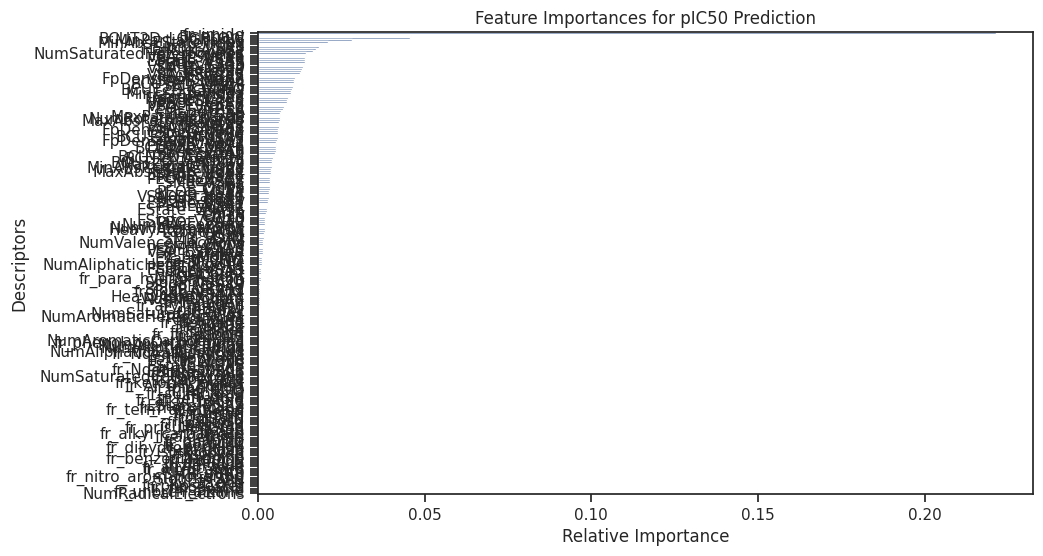

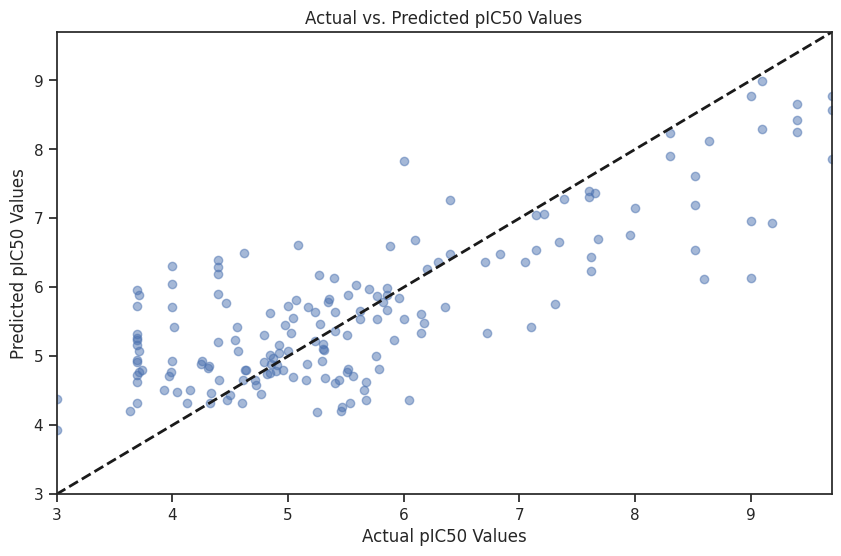

In [50]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have X and y defined already

# Replace inf and -inf in X with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Combine X and y into a single DataFrame to ensure perfect alignment when dropping rows
df_combined = pd.concat([X, y], axis=1)

# Drop rows where any value in X or y is NaN
df_combined_clean = df_combined.dropna()

# Separate X and y after cleaning
X_clean = df_combined_clean.iloc[:, :-1]  # All columns except the last (X)
y_clean = df_combined_clean.iloc[:, -1]   # Last column (y)

# Check if X and y are aligned
print(f"X_clean shape: {X_clean.shape}, y_clean shape: {y_clean.shape}")

# Proceed with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Train the RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest R-squared: {r2}")

# Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_clean.columns[indices])
plt.title('Feature Importances for pIC50 Prediction')
plt.xlabel('Relative Importance')
plt.ylabel('Descriptors')
plt.show()

# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted pIC50 Values')
plt.xlabel('Actual pIC50 Values')
plt.ylabel('Predicted pIC50 Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.show()


In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Replace infinity with NaN in X and y
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# Concatenate X and y into a single DataFrame for simultaneous NaN dropping
data_combined = pd.concat([X, y], axis=1)

# Drop rows where any NaN values are present
data_clean = data_combined.dropna()

# Separate X and y again after cleaning
X_clean = data_clean.iloc[:, :-1]  # All columns except the last one (which is y)
y_clean = data_clean.iloc[:, -1]   # The last column is y

# Standardizing the data to prevent large values from causing issues
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)  # Scale X to have zero mean and unit variance

# Set up the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation setup with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_scaled, y_clean, cv=kf, scoring='neg_mean_squared_error')

# Output the scores
print("Cross-validation MSE scores:", -cv_scores)  # Negate to get positive MSE values
print("Average MSE:", -np.mean(cv_scores))


Cross-validation MSE scores: [0.99647283 1.02514465 1.38029234 1.14745804 1.02890693]
Average MSE: 1.1156549581728252


In [ ]:
from google.colab import files

# Upload your CSV file (a dialog will open for you to choose the file)
uploaded = files.upload()



In [ ]:
import os
# List files in the current directory to check the filename
os.listdir()



['.config', 'ligands (1).csv', 'ligands.csv', 'sample_data']

In [ ]:
import pandas as pd

# Load your CSV file with a different encoding
ligands_df = pd.read_csv('ligands.csv', encoding='ISO-8859-1')

# Display the first few rows to ensure it's loaded correctly
ligands_df.head()


,SMILES
0,CCCCCCCCCCCCCCCC=O
1,COC1=C(C=CC(=C1)C=O)O
2,CC1(C2CCC(O1)(CC2)C)C
3,CC1=CC=C(C=C1)C(C)C
4,CCCCCCCCCC(=O)C


In [ ]:
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

# List of descriptors to calculate
descriptor_names = [desc_name[0] for desc_name in Descriptors.descList]

# Initialize descriptor calculator
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# Function to compute descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return calculator.CalcDescriptors(mol)
    else:
        return [None] * len(descriptor_names)

# Apply the function to compute descriptors for all ligands
ligands_df['descriptors'] = ligands_df['SMILES'].apply(compute_descriptors)

# Split the descriptors into individual columns
desc_df = pd.DataFrame(ligands_df['descriptors'].tolist(), columns=descriptor_names)

# Merge with the original DataFrame (optional)
ligands_df = pd.concat([ligands_df, desc_df], axis=1)

# Drop any unnecessary columns (like SMILES) if needed
ligands_df.drop(columns=['SMILES', 'descriptors'], inplace=True)


In [ ]:
# Check if the model still exists in the workspace
try:
    print(rf_model)  # Replace 'rf_model' with the name of your model
except NameError:
    print("The model is not in memory. You'll need to reload or retrain it.")


RandomForestRegressor(random_state=42)


In [ ]:
import pandas as pd

# Load the ligands CSV file
ligands_df = pd.read_csv('ligands.csv', encoding='ISO-8859-1')

# Display the first few rows to confirm it loaded correctly
ligands_df.head()


,SMILES
0,CCCCCCCCCCCCCCCC=O
1,COC1=C(C=CC(=C1)C=O)O
2,CC1(C2CCC(O1)(CC2)C)C
3,CC1=CC=C(C=C1)C(C)C
4,CCCCCCCCCC(=O)C


In [ ]:
!pip install rdkit-pypi


In [ ]:
import pandas as pd

# Load your CSV file
ligands_df = pd.read_csv('ligands.csv', encoding='ISO-8859-1')  # Replace with your actual CSV filename

# Display the first few rows to check if everything was loaded correctly
ligands_df.head()



,SMILES
0,CCCCCCCCCCCCCCCC=O
1,COC1=C(C=CC(=C1)C=O)O
2,CC1(C2CCC(O1)(CC2)C)C
3,CC1=CC=C(C=C1)C(C)C
4,CCCCCCCCCC(=O)C


In [ ]:
# Import RDKit libraries
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Define the list of descriptor names (this will include all available RDKit descriptors)
descriptor_names = [desc_name[0] for desc_name in Descriptors.descList]

# Create a function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to molecule object
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)  # Descriptor calculator
    if mol:
        return calculator.CalcDescriptors(mol)  # Compute descriptors
    else:
        return [None] * len(descriptor_names)  # Return None if invalid SMILES

# Apply the descriptor computation function to each SMILES string
ligands_df[descriptor_names] = ligands_df['SMILES'].apply(compute_descriptors).apply(pd.Series)

# Display the dataframe with computed descriptors
ligands_df.head()


<ipython-input-61-860a9d903d24>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ligands_df[descriptor_names] = ligands_df['SMILES'].apply(compute_descriptors).apply(pd.Series)
<ipython-input-61-860a9d903d24>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ligands_df[descriptor_names] = ligands_df['SMILES'].apply(compute_descriptors).apply(pd.Series)
<ipython-input-61-860a9d903d24>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

,SMILES,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCCCCCCCCCCCCCCC=O,10.106207,0.761667,10.106207,0.761667,0.282397,240.431,208.175,240.245316,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
1,COC1=C(C=CC(=C1)C=O)O,10.248745,0.039907,10.248745,0.039907,0.647744,152.149,144.085,152.047344,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC1(C2CCC(O1)(CC2)C)C,6.060185,0.157986,6.060185,0.157986,0.521026,154.253,136.109,154.135765,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CC1=CC=C(C=C1)C(C)C,2.212963,0.653333,2.212963,0.653333,0.553258,134.222,120.110,134.109550,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCCCCCCCCC(=O)C,10.578934,0.336628,10.578934,0.336628,0.507358,170.296,148.120,170.167065,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [ ]:
# Save the dataframe with descriptors into a new CSV file
ligands_df.to_csv('ligands_with_descriptors.csv', index=False)

# Display confirmation
print("Molecular descriptors have been saved to 'ligands_with_descriptors.csv'.")


Molecular descriptors have been saved to 'ligands_with_descriptors.csv'.


In [ ]:
# Check which columns exist in the dataframe
print(ligands_df.columns)
X_new_ligands = ligands_df.drop(columns=['SMILES'], errors='ignore')
print(X_new_ligands.columns)


Index(['SMILES', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=209)
Index(['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=208)


In [ ]:
# Assuming you have X_train and y_train for refitting the model
rf_model.fit(X_train, y_train)

# Now predict the pIC50 for the new ligands
predicted_pIC50 = rf_model.predict(X_new_ligands)

# Add predictions to the original DataFrame
ligands_df['predicted_pIC50'] = predicted_pIC50

# Display the ligands and predicted pIC50
print(ligands_df[['predicted_pIC50']])


    predicted_pIC50
0          5.972179
1          6.113798
2          6.554630
3          6.077168
4          6.418666
5          6.424474
6          5.480120
7          5.898220
8          6.505931
9          5.288472
10         6.220782
11         5.901780
12         5.651159
13         6.118371
14         6.338763
15         6.429637
16         6.082363
17         5.328392
18         7.237249
19         6.719621
20         5.680929
21         5.535247
22         5.989898
23         6.195362
24         6.286321
25         6.286321
26         6.655339
27         5.448683
28         5.640796
29         5.779359
30         6.538726
31         6.359217
32         6.425226
33         5.951797
34         6.316881
35         6.256603
36         6.136249
37         6.245841
38         6.799732
39         6.037293
40         6.072597
41         5.951797
42         6.361405
43         6.361405
44         6.361405
45         6.168377
46         6.230026
47         6.398918
48         6.475054


In [ ]:
# Assuming 'predicted_pIC50' contains your predicted values
import pandas as pd
from google.colab import files

# Create a DataFrame for pIC50
pIC50_df = pd.DataFrame({'Predicted pIC50': predicted_pIC50})

# Export the DataFrame to Excel
pIC50_df.to_excel('predicted_pIC50.xlsx', index=False)

# Download the Excel file
files.download('predicted_pIC50.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>